I performed `EDA` on whole response of city `PATNA`. And I found that `AREA` column doesn't contains a specific area lke `BUILTUP_AREA` or `CARPET_AREA` instead it contains anyone area which were uploaded by the broker in the website.

> Now I have to adjust my pipeline to work with only `BUILTUP_AREA` if `BUILTUP_AREA` is **NaN** for any property then I have to estimate it from other given area.

In [ ]:
import json

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

In [117]:
from warnings import filterwarnings


filterwarnings('ignore', category=FutureWarning)

In [2]:
with open('data/other cities/patna_1.3k_better.json') as f:
    patna = json.load(f)

In [3]:
full_df: pd.DataFrame = (
    pd.DataFrame(patna['srp'])
    .query("PROPERTY_TYPE!=['farm house', 'other', 'studio apartment']")
    .query("PREFERENCE!='p'")
    .sort_values('PRICE')
    .map(lambda x: x.lower() if isinstance(x, str) else x)  # type: ignore
    .reset_index(drop=True)
)
print(full_df.shape)
full_df.head()

(3104, 222)


,SPID,PROP_ID,PHOTO_URL,MEDIUM_PHOTO_URL,PREFERENCE,DESCRIPTION,PROPERTY_TYPE,CITY,LOCALITY,AREA_UNIT,...,CONFIG_GROUP,BROKER_GROUP,QUALITY_BUCKET,GENUINENESS_BUCKET,DATA_QUALITY_INFO,IS_CREDIT_LISTING,SHOW_ONLY_START_PRICE,OTHER_CITY,AVAILABILITY_DATE__U,MODIFY_DATE__U
0,57379358,n57379358,NaN,NaN,s,we are the proud owners of this 3 bhk apartmen...,residential apartment,patna,east boring canal road,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,69922868,l69922868,NaN,NaN,s,best in class property available at danapur lo...,residential apartment,patna,danapur,sq.ft.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,70719824,j70719824,https://mediacdn.99acres.com/media1/21938/18/4...,https://mediacdn.99acres.com/media1/21938/18/4...,s,i am looking for buyer to purchase house/villa...,independent house/villa,patna,bajrangpuri,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,66805666,c66805666,NaN,NaN,s,vastu vihar is one of patna's most sought afte...,residential apartment,patna,saguna more,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,71166980,v71166980,https://mediacdn.99acres.com/media1/22168/12/4...,https://mediacdn.99acres.com/media1/22168/12/4...,s,3 fully developed flats in ground floor (g2b &...,residential apartment,patna,shivpuri,sq.ft.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
full_df['PROP_ID'] = 'https://99acres.com/' + full_df['PROP_ID'].str.upper()

In [5]:
# full_df.columns[df.columns.str.contains('carpet|builtup', case=False)].tolist()
full_df.columns[full_df.columns.str.contains('area|sqft', case=False)].sort_values()  # .tolist()

Index(['AREA', 'AREA_UNIT', 'AREA_UNIT__U', 'BUILTUP_AREA', 'BUILTUP_SQFT',
       'CARPETAREA_UNIT', 'CARPETAREA_UNIT__U', 'CARPET_AREA', 'CARPET_SQFT',
       'COM_AREA_TYPE', 'MAX_AREA', 'MAX_AREA_SQFT', 'MIN_AREA',
       'MIN_AREA_SQFT', 'PRICE_PER_UNIT_AREA', 'PRICE_SQFT', 'SECONDARY_AREA',
       'SUPERAREA_UNIT', 'SUPERAREA_UNIT__U', 'SUPERBUILTUPAREA_UNIT',
       'SUPERBUILTUPAREA_UNIT__U', 'SUPERBUILTUP_AREA', 'SUPERBUILTUP_SQFT',
       'SUPER_AREA', 'SUPER_SQFT'],
      dtype='object')

In [6]:
full_df[
    [
        'PROP_ID',
        'PREFERENCE',
        'PROPERTY_TYPE',
        'PRICE',
        'AREA',
        'CARPET_SQFT',
        'SUPERBUILTUP_SQFT',
        'BUILTUP_SQFT',
        'SUPER_AREA',
    ]
].fillna('••••••••••').sample(2)

,PROP_ID,PREFERENCE,PROPERTY_TYPE,PRICE,AREA,CARPET_SQFT,SUPERBUILTUP_SQFT,BUILTUP_SQFT,SUPER_AREA
1305,https://99acres.com/Y70569612,r,residential apartment,"25,000",1650 sq.ft.,••••••••••,1650.0,••••••••••,••••••••••
473,https://99acres.com/I70331742,r,independent house/villa,"12,000",2755 sq.ft.,1101.0,••••••••••,1297.0,2755.0


In [7]:
area_cols = ['CARPET_SQFT', 'SUPERBUILTUP_SQFT', 'BUILTUP_SQFT', 'SUPER_SQFT']
imp_cols = 'PROP_ID PREFERENCE PRICE AREA PROPERTY_TYPE'.split()

In [42]:
main_df = (
    full_df[imp_cols + area_cols]
    .copy()
    .astype(
        {
            'BUILTUP_SQFT': float,
            'CARPET_SQFT': float,
            'SUPERBUILTUP_SQFT': float,
            'SUPER_SQFT': float,
        }
    )
)

In [33]:
main_df['PREFERENCE'].value_counts()

PREFERENCE
s    1888
r    1216
Name: count, dtype: int64

In [38]:
for i in ['s', 'r']:
    print(f"PREFERENCE=={i}")
    print(main_df.query("PREFERENCE==@i")['PROPERTY_TYPE'].value_counts())
    print()

PREFERENCE==s
PROPERTY_TYPE
residential land             1015
residential apartment         607
independent/builder floor     137
independent house/villa       129
Name: count, dtype: int64

PREFERENCE==r
PROPERTY_TYPE
residential apartment        505
independent house/villa      486
independent/builder floor    225
Name: count, dtype: int64



In [9]:
main_df[area_cols].isnull().sum()

CARPET_SQFT          2010
SUPERBUILTUP_SQFT    2623
BUILTUP_SQFT         2362
SUPER_SQFT           1716
dtype: int64

In [10]:
main_df[area_cols].notnull().sum()

CARPET_SQFT          1094
SUPERBUILTUP_SQFT     481
BUILTUP_SQFT          742
SUPER_SQFT           1388
dtype: int64

In [11]:
for col in area_cols:
    print(col)
    print(main_df[main_df[col].notnull()]['PROPERTY_TYPE'].value_counts())
    print()

CARPET_SQFT
PROPERTY_TYPE
residential apartment        714
independent/builder floor    197
independent house/villa      182
residential land               1
Name: count, dtype: int64

SUPERBUILTUP_SQFT
PROPERTY_TYPE
residential apartment        451
independent/builder floor     29
residential land               1
Name: count, dtype: int64

BUILTUP_SQFT
PROPERTY_TYPE
residential apartment        270
independent/builder floor    245
independent house/villa      226
residential land               1
Name: count, dtype: int64

SUPER_SQFT
PROPERTY_TYPE
residential land           1006
independent house/villa     382
Name: count, dtype: int64



In [12]:
# Extract rows which has all the areas
all_area = main_df[
    main_df['BUILTUP_SQFT'].notnull()
    & main_df['CARPET_SQFT'].notnull()
    & main_df['SUPERBUILTUP_SQFT'].notnull()
    & main_df['SUPER_SQFT'].notnull()
]
all_area

,PROP_ID,PREFERENCE,PRICE,AREA,PROPERTY_TYPE,CARPET_SQFT,SUPERBUILTUP_SQFT,BUILTUP_SQFT,SUPER_SQFT
1180,https://99acres.com/Z70520606,s,21 l,8168 sq.ft.,residential land,0,0,0,8168


In [32]:
# Rows with no area feature
no_area = main_df[
    main_df['BUILTUP_SQFT'].isnull()
    & main_df['CARPET_SQFT'].isnull()
    & main_df['SUPERBUILTUP_SQFT'].isnull()
    & main_df['SUPER_SQFT'].isnull()
]
no_area

,PROP_ID,PREFERENCE,PRICE,AREA,PROPERTY_TYPE,CARPET_SQFT,SUPERBUILTUP_SQFT,BUILTUP_SQFT,SUPER_SQFT
44,https://99acres.com/Z70682054,s,1.1 - 1.39 cr,1570-1990 sq.ft.,residential apartment,NaN,NaN,NaN,NaN
62,https://99acres.com/C70106744,s,1.12 - 1.34 cr,1606-1915 sq.ft.,residential apartment,NaN,NaN,NaN,NaN
172,https://99acres.com/B70106746,s,1.66 - 1.89 cr,2372-2702 sq.ft.,residential apartment,NaN,NaN,NaN,NaN
309,https://99acres.com/Q69761658,s,10.99 - 16.49 l,1000-1500 sq.ft.,residential land,NaN,NaN,NaN,NaN
310,https://99acres.com/V69007170,s,10.99 - 26.38 l,1000-2400 sq.ft.,residential land,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3099,https://99acres.com/M70802242,s,price on request,995-1190 sq.ft.,residential apartment,NaN,NaN,NaN,NaN
3100,https://99acres.com/K68461582,s,price on request,2354-3027 sq.ft.,residential apartment,NaN,NaN,NaN,NaN
3101,https://99acres.com/Y68461580,s,price on request,1561-2620 sq.ft.,residential apartment,NaN,NaN,NaN,NaN
3102,https://99acres.com/I70322352,s,price on request,1444-1502 sq.ft.,residential apartment,NaN,NaN,NaN,NaN


In [43]:
b_c_sb = main_df[
    main_df['BUILTUP_SQFT'].notnull()
    & main_df['CARPET_SQFT'].notnull()
    & main_df['SUPERBUILTUP_SQFT'].notnull()
]
b_c_sb

,PROP_ID,PREFERENCE,PRICE,AREA,PROPERTY_TYPE,CARPET_SQFT,SUPERBUILTUP_SQFT,BUILTUP_SQFT,SUPER_SQFT
32,https://99acres.com/C63081542,s,1.01 cr,1560 sq.ft.,residential apartment,1145.00,1560.00,1200.0,NaN
114,https://99acres.com/U68769782,s,1.3 cr,1709 sq.ft.,residential apartment,1061.00,1709.00,1367.0,NaN
145,https://99acres.com/W52806590,s,1.5 cr,1700 sq.ft.,residential apartment,1550.00,1700.00,1625.0,NaN
221,https://99acres.com/Z70645720,r,"10,000",1000 sq.ft.,residential apartment,800.00,1000.00,900.0,NaN
241,https://99acres.com/U69789736,r,"10,000",1095 sq.ft.,residential apartment,712.00,1095.00,845.0,NaN
...,...,...,...,...,...,...,...,...,...
2964,https://99acres.com/Z65769282,s,94 l,1565 sq.ft.,residential apartment,996.00,1565.00,1265.0,NaN
2967,https://99acres.com/Y70514654,s,95 l,1305 sq.ft.,residential apartment,850.00,1305.00,1008.0,NaN
2981,https://99acres.com/B64274042,s,96.53 l,1485 sq.ft.,residential apartment,905.00,1485.00,988.0,NaN
2984,https://99acres.com/P69793326,s,97.74 l,1629 sq.ft.,residential apartment,1086.83,1629.41,1253.4,NaN


In [71]:
def calc_ratio(df: pd.DataFrame, f1: str, f2: str) -> None:
    ratio = round(df[f1].div(df[f2]).mean(), 3)
    print(f'Ration b/w {f1} and {f2}:'.rjust(50), ratio)

In [76]:
calc_ratio(b_c_sb, 'CARPET_SQFT', 'BUILTUP_SQFT')
calc_ratio(b_c_sb, 'SUPERBUILTUP_SQFT', 'BUILTUP_SQFT')

          Ration b/w CARPET_SQFT and BUILTUP_SQFT: 0.875
    Ration b/w SUPERBUILTUP_SQFT and BUILTUP_SQFT: 1.152


In [74]:
b_c = main_df[main_df['BUILTUP_SQFT'].notnull() & main_df['CARPET_SQFT'].notnull()]
b_c

,PROP_ID,PREFERENCE,PRICE,AREA,PROPERTY_TYPE,CARPET_SQFT,SUPERBUILTUP_SQFT,BUILTUP_SQFT,SUPER_SQFT
4,https://99acres.com/V71166980,s,1 cr,920 sq.ft.,residential apartment,900.0,NaN,920.0,NaN
7,https://99acres.com/Y71070340,s,1 cr,1518 sq.ft.,residential apartment,1360.0,NaN,1518.0,NaN
13,https://99acres.com/K69836520,s,1 cr,1550 sq.ft.,independent/builder floor,1200.0,NaN,1550.0,NaN
19,https://99acres.com/C69271170,s,1 cr,1340 sq.ft.,residential apartment,1075.0,NaN,1340.0,NaN
24,https://99acres.com/O70183700,s,1 cr,1600 sq.ft.,independent/builder floor,1400.0,NaN,1600.0,NaN
...,...,...,...,...,...,...,...,...,...
3045,https://99acres.com/I70266780,s,price on request,1449 sq.ft.,residential apartment,934.0,1449.0,1035.0,NaN
3059,https://99acres.com/F70539902,s,price on request,1200 sq.ft.,independent/builder floor,1000.0,NaN,1200.0,NaN
3061,https://99acres.com/Y70556754,r,price on request,3500 sq.ft.,independent/builder floor,2700.0,NaN,3500.0,NaN
3064,https://99acres.com/H70617146,s,price on request,2300 sq.ft.,independent/builder floor,1800.0,NaN,2300.0,NaN


In [77]:
calc_ratio(b_c, 'CARPET_SQFT', 'BUILTUP_SQFT')

          Ration b/w CARPET_SQFT and BUILTUP_SQFT: 0.842


In [78]:
b_sb = main_df[main_df['BUILTUP_SQFT'].notnull() & main_df['SUPERBUILTUP_SQFT'].notnull()]
b_sb

,PROP_ID,PREFERENCE,PRICE,AREA,PROPERTY_TYPE,CARPET_SQFT,SUPERBUILTUP_SQFT,BUILTUP_SQFT,SUPER_SQFT
32,https://99acres.com/C63081542,s,1.01 cr,1560 sq.ft.,residential apartment,1145.00,1560.00,1200.0,NaN
90,https://99acres.com/E52441854,s,1.25 cr,1400 sq.ft.,residential apartment,NaN,1400.00,1200.0,NaN
100,https://99acres.com/G68306012,s,1.25 cr,1860 sq.ft.,residential apartment,NaN,1860.00,1616.0,NaN
114,https://99acres.com/U68769782,s,1.3 cr,1709 sq.ft.,residential apartment,1061.00,1709.00,1367.0,NaN
145,https://99acres.com/W52806590,s,1.5 cr,1700 sq.ft.,residential apartment,1550.00,1700.00,1625.0,NaN
...,...,...,...,...,...,...,...,...,...
2967,https://99acres.com/Y70514654,s,95 l,1305 sq.ft.,residential apartment,850.00,1305.00,1008.0,NaN
2981,https://99acres.com/B64274042,s,96.53 l,1485 sq.ft.,residential apartment,905.00,1485.00,988.0,NaN
2984,https://99acres.com/P69793326,s,97.74 l,1629 sq.ft.,residential apartment,1086.83,1629.41,1253.4,NaN
2986,https://99acres.com/R71001238,s,97.98 l,1633 sq.ft.,residential apartment,NaN,1633.00,1270.0,NaN


In [79]:
calc_ratio(b_sb, 'SUPERBUILTUP_SQFT', 'BUILTUP_SQFT')

    Ration b/w SUPERBUILTUP_SQFT and BUILTUP_SQFT: 1.161


In [80]:
b_su = main_df[main_df['BUILTUP_SQFT'].notnull() & main_df['SUPER_SQFT'].notnull()]
b_su.head(8)

,PROP_ID,PREFERENCE,PRICE,AREA,PROPERTY_TYPE,CARPET_SQFT,SUPERBUILTUP_SQFT,BUILTUP_SQFT,SUPER_SQFT
96,https://99acres.com/B49941894,s,1.25 cr,1100 sq.ft.,independent house/villa,1100.0,NaN,1200.0,1100.0
181,https://99acres.com/Q69692678,s,1.8 cr,2 sq.ft.,independent house/villa,NaN,NaN,2926.0,2.0
281,https://99acres.com/B71054184,r,"10,000",1100 sq.ft.,independent house/villa,1000.0,NaN,1050.0,1100.0
284,https://99acres.com/H70736664,r,"10,000",1100 sq.ft.,independent house/villa,880.0,NaN,990.0,1100.0
288,https://99acres.com/S54820606,r,"10,000",3200 sq.ft.,independent house/villa,650.0,NaN,750.0,3200.0
294,https://99acres.com/L71151144,r,"10,500",2000 sq.ft.,independent house/villa,1250.0,NaN,1500.0,2000.0
325,https://99acres.com/W68057356,r,"11,000",2800 sq.ft.,independent house/villa,450.0,NaN,500.0,2800.0
335,https://99acres.com/D66617872,r,"11,000",1200 sq.ft.,independent house/villa,250.0,NaN,300.0,1200.0


There is a problem in `https://99acres.com/Q69692678` property.

In [83]:
calc_ratio(b_su, 'SUPER_SQFT', 'BUILTUP_SQFT')
calc_ratio(b_su, 'BUILTUP_SQFT', 'SUPER_SQFT')

           Ration b/w SUPER_SQFT and BUILTUP_SQFT: inf
           Ration b/w BUILTUP_SQFT and SUPER_SQFT: 38.352


In [85]:
print(b_su['BUILTUP_SQFT'].div(b_su['SUPER_SQFT']).mean())
print(b_su['BUILTUP_SQFT'].div(b_su['SUPER_SQFT']).median())
print(b_su['BUILTUP_SQFT'].div(b_su['SUPER_SQFT']).min())
print(b_su['BUILTUP_SQFT'].div(b_su['SUPER_SQFT']).max())

38.35222133937909
0.9
0.0
1463.0


In [29]:
# When PRICE is `price on request` then all the areas are null
main_df.query("PRICE=='price on request'")

,PROP_ID,PREFERENCE,PRICE,AREA,PROPERTY_TYPE,CARPET_SQFT,SUPERBUILTUP_SQFT,BUILTUP_SQFT,SUPER_SQFT
2993,https://99acres.com/X71192738,s,price on request,1300-1790 sq.ft.,residential apartment,NaN,NaN,NaN,NaN
2994,https://99acres.com/L68743932,s,price on request,1225-1790 sq.ft.,residential apartment,NaN,NaN,NaN,NaN
2995,https://99acres.com/O68743930,s,price on request,1075-1350 sq.ft.,residential apartment,NaN,NaN,NaN,NaN
2996,https://99acres.com/H70106234,s,price on request,1155-1260 sq.ft.,residential apartment,NaN,NaN,NaN,NaN
2997,https://99acres.com/K70704682,s,price on request,2506 sq.ft.,residential apartment,NaN,2506.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3099,https://99acres.com/M70802242,s,price on request,995-1190 sq.ft.,residential apartment,NaN,NaN,NaN,NaN
3100,https://99acres.com/K68461582,s,price on request,2354-3027 sq.ft.,residential apartment,NaN,NaN,NaN,NaN
3101,https://99acres.com/Y68461580,s,price on request,1561-2620 sq.ft.,residential apartment,NaN,NaN,NaN,NaN
3102,https://99acres.com/I70322352,s,price on request,1444-1502 sq.ft.,residential apartment,NaN,NaN,NaN,NaN


### Clip area values

In [100]:
def clip_col(df: pd.DataFrame, col: str, quantile: float = 0.99) -> None:
    df[col] = df[col].clip(upper=df[col].quantile(quantile))

In [101]:
for col in area_cols:
    print(col)
    print(main_df[col].max())
    clip_col(main_df, col, 0.99)
    print(main_df[col].max())
    print()

CARPET_SQFT
611999.995104
3041.999999999962

SUPERBUILTUP_SQFT
15000.0
2524.799999999999

BUILTUP_SQFT
683999.994528
4426.200000000006

SUPER_SQFT
28314000.000000395
446207.99999999563



### Scatter plot between area cols

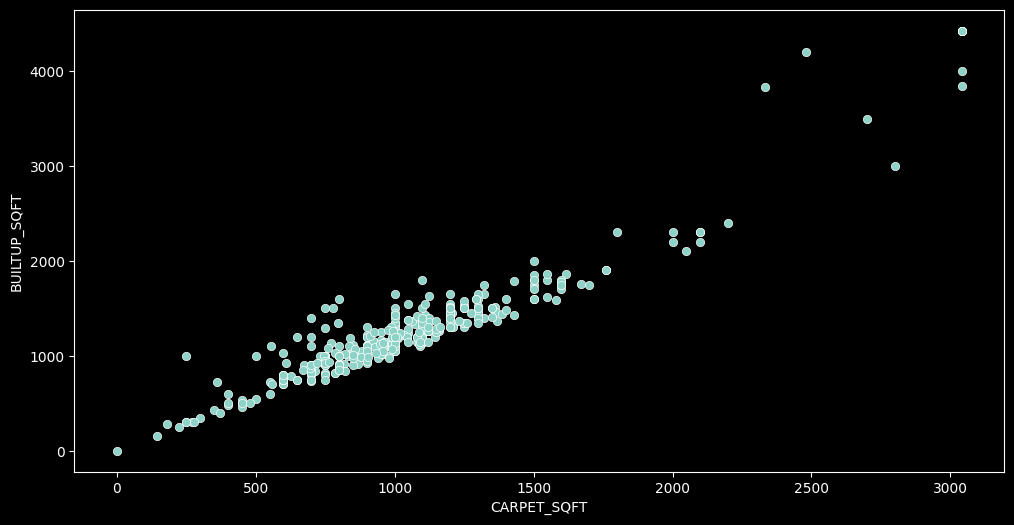

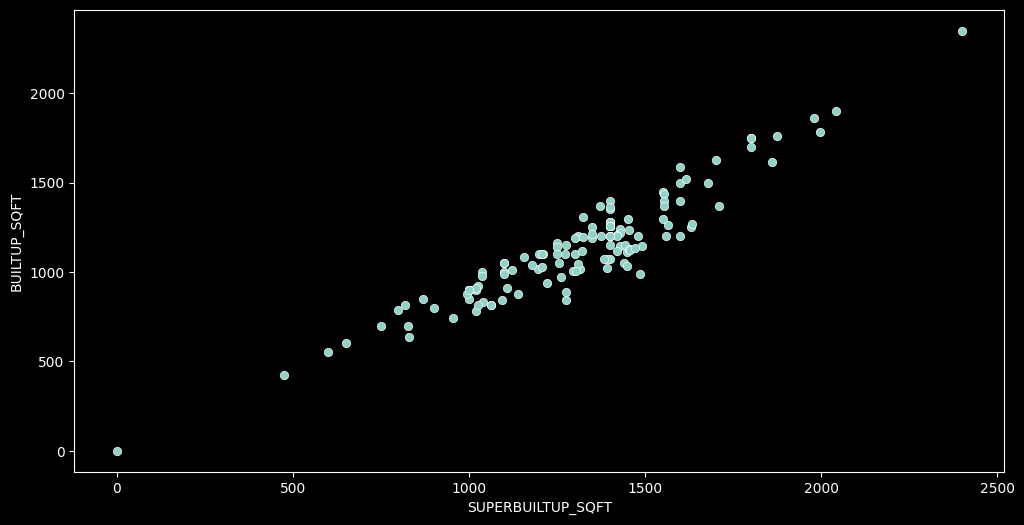

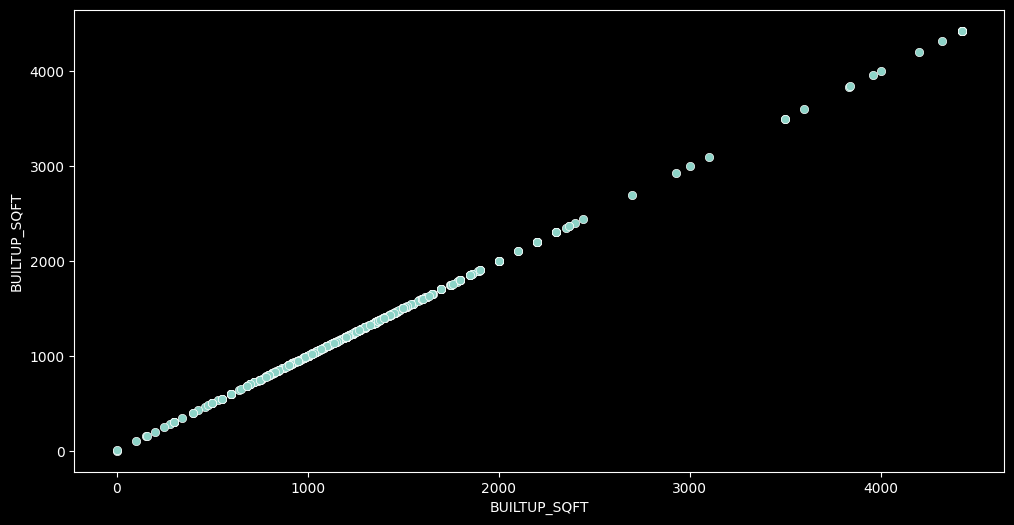

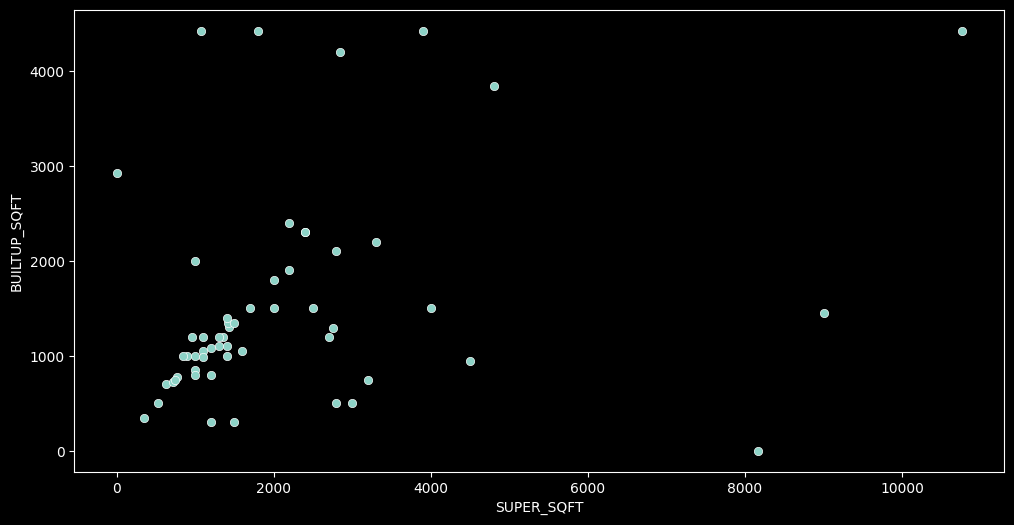

In [118]:
for col in area_cols:
    plt.figure(figsize=(12, 6))
    sns.scatterplot(main_df, x=col, y='BUILTUP_SQFT')

In [103]:
main_df[main_df['CARPET_SQFT'] == main_df['CARPET_SQFT'].max()]

,PROP_ID,PREFERENCE,PRICE,AREA,PROPERTY_TYPE,CARPET_SQFT,SUPERBUILTUP_SQFT,BUILTUP_SQFT,SUPER_SQFT
135,https://99acres.com/D54794796,r,1.4 l,4400 sq.ft.,independent house/villa,3042.0,NaN,NaN,4400.000000
195,https://99acres.com/Y70310220,s,10 cr,11000 sq.ft.,residential apartment,3042.0,NaN,4426.2,NaN
755,https://99acres.com/W71076672,r,"15,000",9900 sq.ft.,independent/builder floor,3042.0,NaN,NaN,NaN
1063,https://99acres.com/U70471008,s,2 cr,4000 sq.ft.,independent house/villa,3042.0,NaN,4000.0,NaN
1087,https://99acres.com/B52146954,s,2.25 cr,10763 sq.ft.,independent house/villa,3042.0,NaN,4426.2,10763.915051
1384,https://99acres.com/O70523954,s,3 cr,2100 sq.ft.,independent house/villa,3042.0,NaN,NaN,2100.000000
2074,https://99acres.com/T64275632,s,6.5 cr,7500 sq.ft.,independent/builder floor,3042.0,NaN,4426.2,NaN
2249,https://99acres.com/M70937244,s,7 cr,7200 sq.ft.,independent house/villa,3042.0,NaN,NaN,NaN
2250,https://99acres.com/U70227608,s,7 cr,4800 sq.ft.,independent house/villa,3042.0,NaN,3840.0,4800.000000
2309,https://99acres.com/K56100444,r,"7,000",1079 sq.ft.,independent house/villa,3042.0,NaN,4426.2,1079.999991


As we can see above for the same value of `CARPET_SQFT` there are different `BUILTUP_SQFT` value.

### KDEplot for area cols

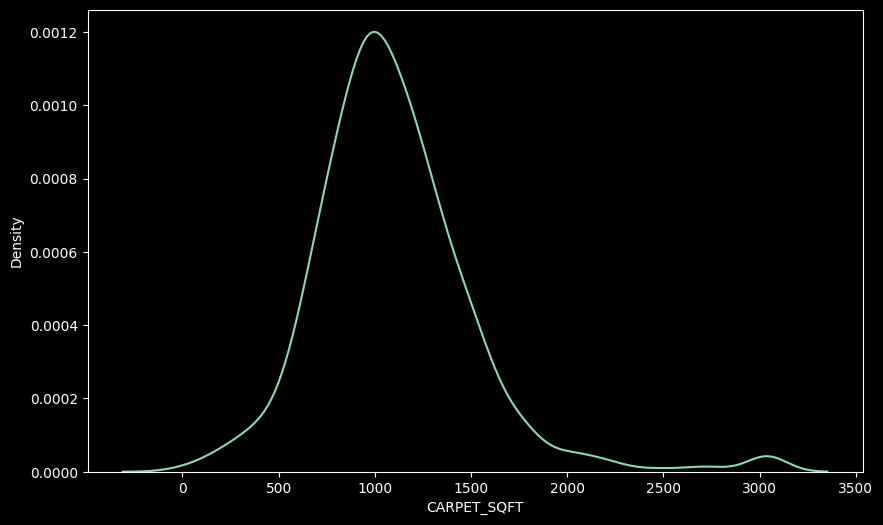

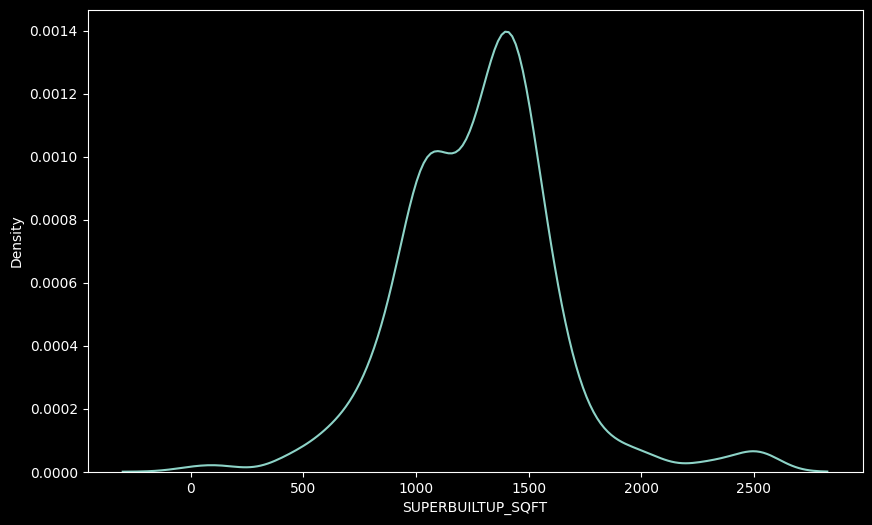

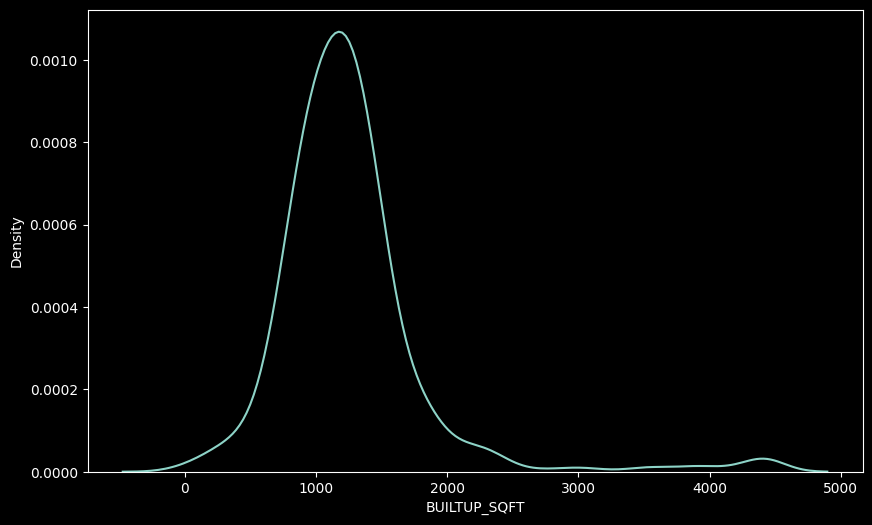

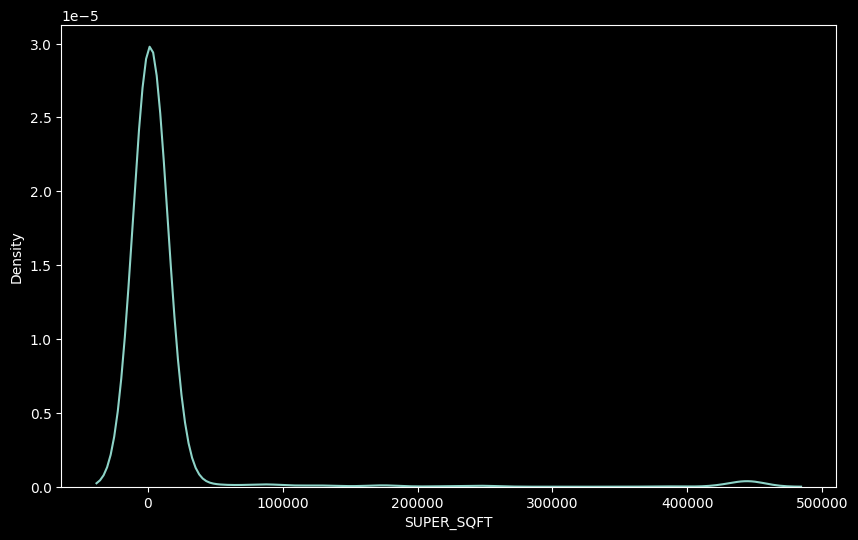

In [124]:
for col in area_cols:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(x=main_df[col])
    break

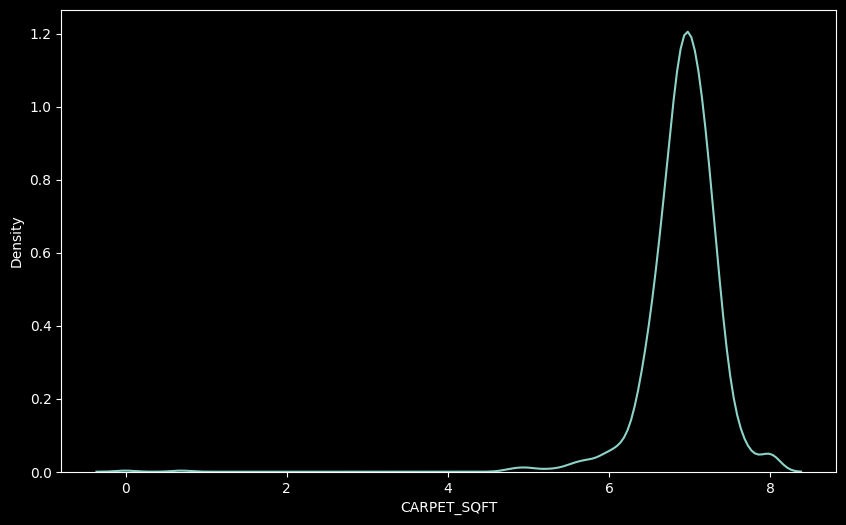

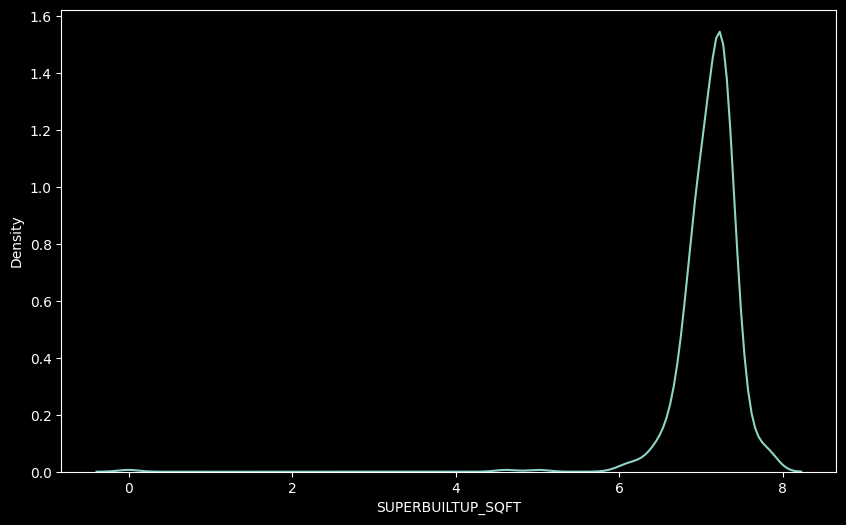

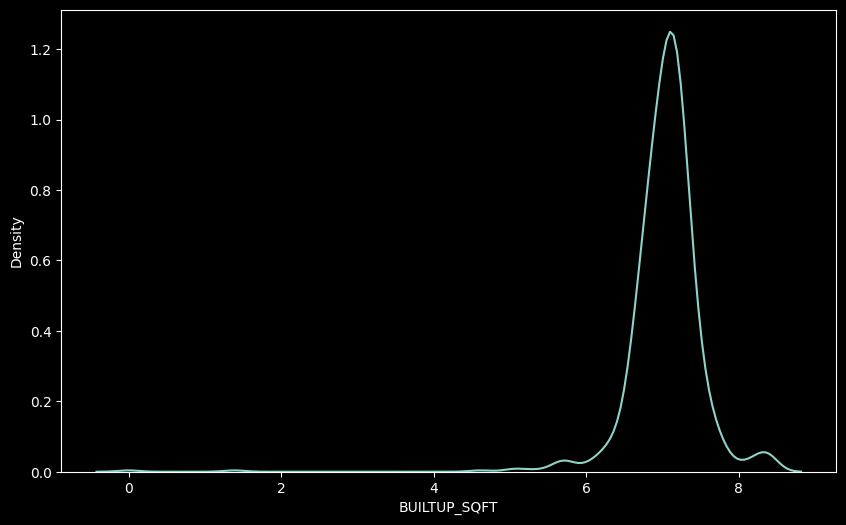

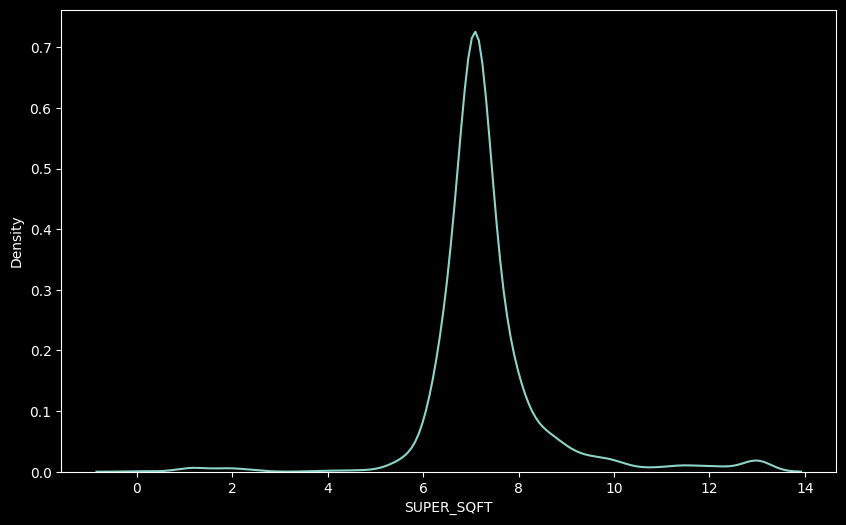

In [128]:
# KDEplot with np.log1p
for col in area_cols:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(x=np.log1p(main_df[col]))

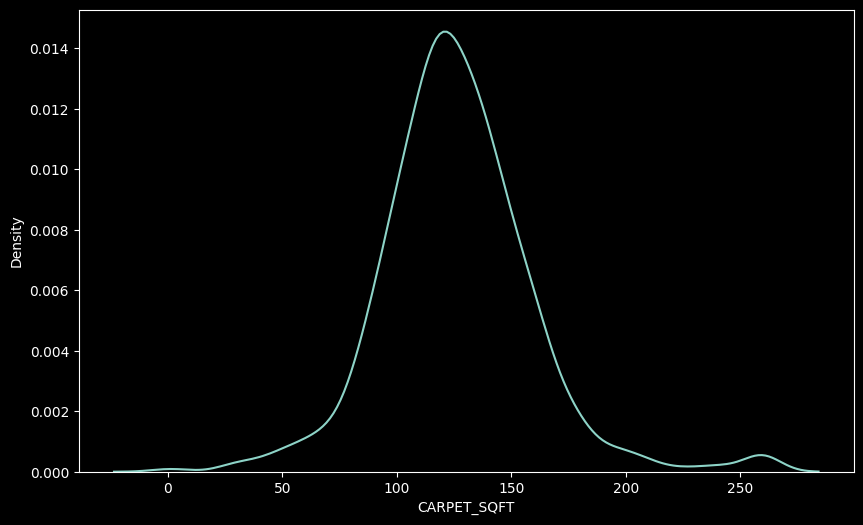

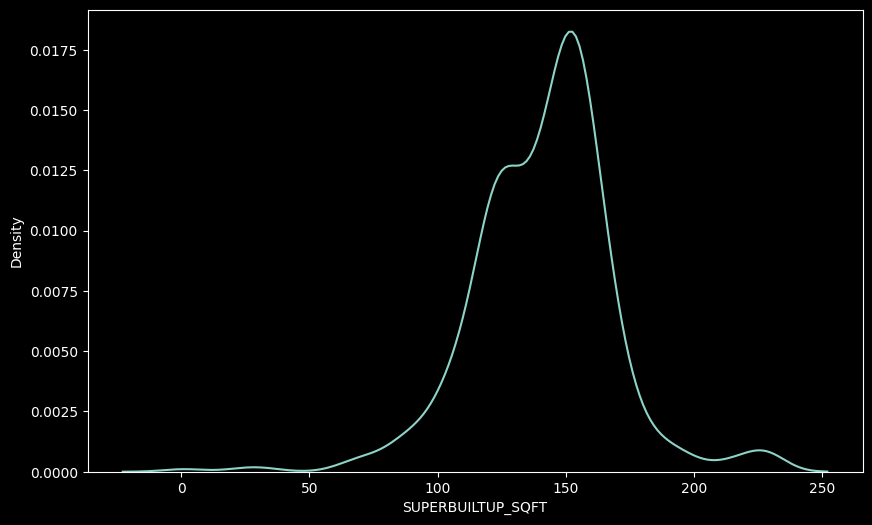

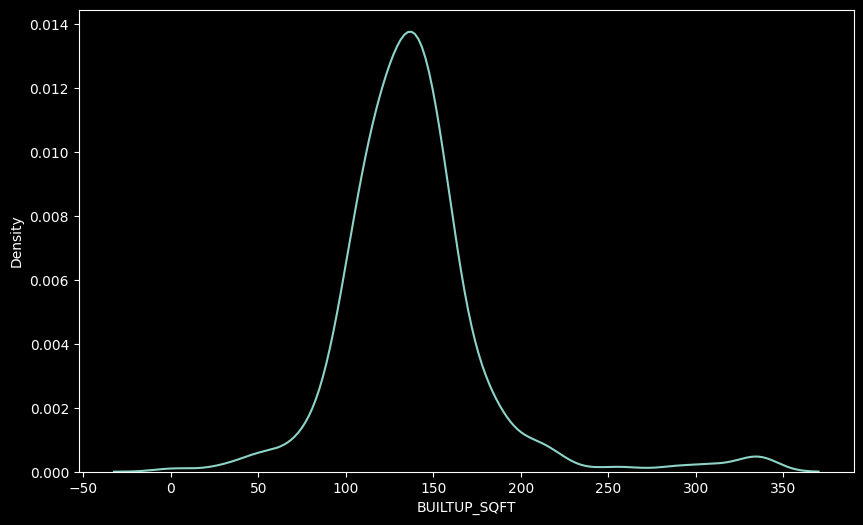

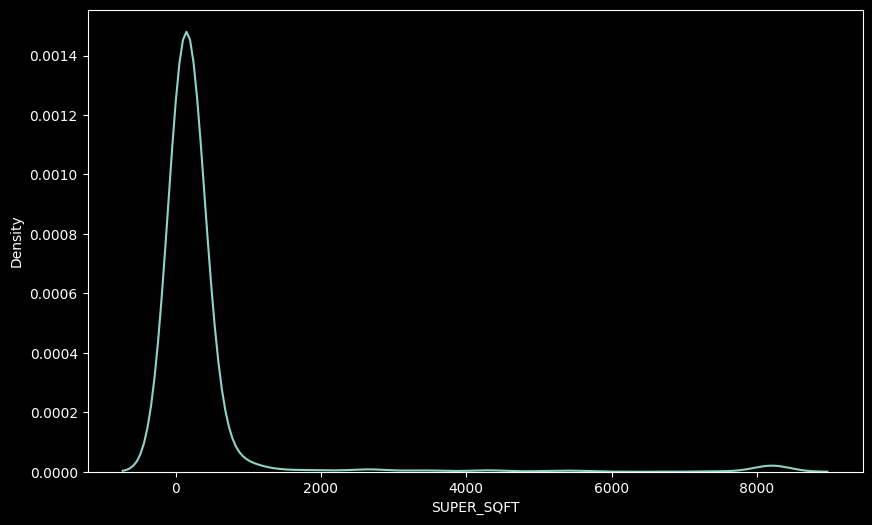

In [127]:
# KDEplot with np.exp2(np.log1p) {composition function}
for col in area_cols:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(x=np.exp2(np.log1p(main_df[col])))